In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib 

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/ec/6c/fab8113424af5049f85717e8e527ca3773299a3c6b02506e66436e19874f/opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata
  Obtaining dependency information for python_version>"3.7" from https://files.pythonhosted.org/packages/a8/e3/06841b7e2b5dab99f6e5ece60db926ce35b9cf351da87ecaf2d75e5d9009/python_version-0.0.2-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.8 MB 3.3 MB/s eta 0:00:12
    --------------------------------------- 0.6/38.8 MB 5.8 MB/s eta 0:00:07
   - -------------------------------------- 1.0/38.8 MB 7.3 MB/s eta 0:00:06
   - -------------------------------------- 1.2/38.8 MB 7.2 MB/s eta 0:00:06
   - -------------------------------------- 1.8/38.8 MB 8.1 MB/s eta 0:00:0

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\sunil\AppData\Local\Temp\pip-install-3o23g15c\tensorflow-gpu_4f0ca50b38a44fcaad90fbf277112bb0\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not buil

In [2]:
import tensorflow as tf 
import os

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Remove Dodgy images - incorrect extensions

In [10]:
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np

In [4]:
data_dir='data'
image_exts=['jpg','jpeg','png','bmp']

In [8]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path=os.path.join(data_dir, image_class, image)
        try:
            img=cv2.imread(image_path)
            tip=imghdr.what(image_path)
            if tip not in image_exts:
                print(' Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

 Image not in ext list data\cats\cat-10-e1573844975155-scaled.jpg
 Image not in ext list data\cats\GettyImages-960998894-e1692805244605.jpg
 Image not in ext list data\lions\705px-Lion_d-Afrique.jpg
 Image not in ext list data\lions\angry-lion-head-logo-icon-sign-outline-flat-design-vector-il.jpg
 Image not in ext list data\lions\cloud-roar-lion-wsazisl.webp


Loading Data

In [13]:
tf.data.Dataset
#this is building a dataset for you and all preprocess data
#this is a generator and not stored in memory
#this has built a datapipeline
data=tf.keras.utils.image_dataset_from_directory('data')

#convert the data to numpy
#allows us to access the data pipeline
data_iterator=data.as_numpy_iterator()

Found 195 files belonging to 2 classes.


In [19]:
#there are two parts in the batch, the image and also labels
#this shows us the entire dataset but in batches of 32
batch=data_iterator.next()
len(batch)

2

In [20]:
#the images are all resized
batch[0].shape

(32, 256, 256, 3)

In [21]:
batch[1]

array([0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0])

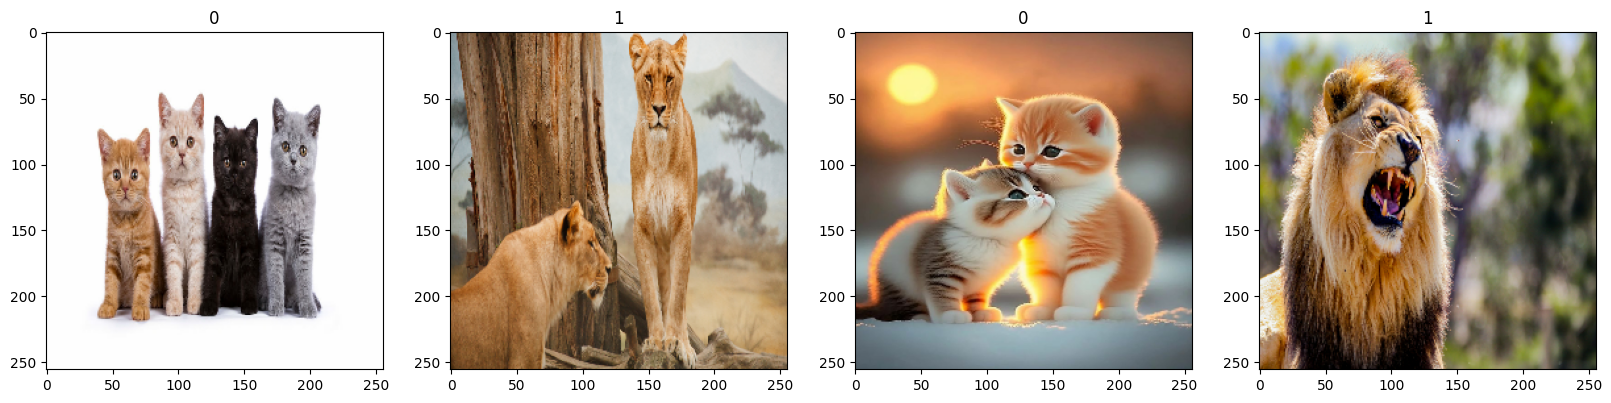

In [33]:
fig, ax= plt.subplots(ncols=4, figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    
    
### 1 - lion
### 0 - cat

Pre processing data

scaling data

In [23]:
#x is images
#y are labels
data=data.map(lambda x,y: (x/255,y))

In [40]:
data.as_numpy_iterator().next()[0].max()

1.0

Split Data

In [41]:
len(data)

7

In [50]:
train_size=int(len(data)*0.7)
val_size=int(len(data)*0.2) + 1
test_size=int(len(data)*0.1) + 1 


train=data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

Building deep learning model

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [53]:
model = Sequential()

#add conv layer and max pool layer
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

#fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Users\sunil\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [54]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
logdir='logs'

In [58]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [59]:
hist=model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 840ms/step - accuracy: 0.4802 - loss: 1.1003 - val_accuracy: 0.4688 - val_loss: 1.0578
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 764ms/step - accuracy: 0.4656 - loss: 0.9111 - val_accuracy: 0.4531 - val_loss: 0.6850
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 873ms/step - accuracy: 0.5240 - loss: 0.6617 - val_accuracy: 0.5469 - val_loss: 0.5861
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 883ms/step - accuracy: 0.5385 - loss: 0.6296 - val_accuracy: 0.6562 - val_loss: 0.6142
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 847ms/step - accuracy: 0.6646 - loss: 0.5939 - val_accuracy: 0.6250 - val_loss: 0.5590
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 928ms/step - accuracy: 0.7292 - loss: 0.5227 - val_accuracy: 0.7344 - val_loss: 0.5298
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 908ms/step - accuracy: 0.8583 - loss: 0.4850 - val_accuracy: 0.7812 - val_loss: 0.4750
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 861ms/step - accuracy: 0.7708 - loss: 0.4736 - val_accuracy: 0.8594 - val_loss:

In [60]:
hist.history

{'accuracy': [0.4765625,
  0.4609375,
  0.53125,
  0.5390625,
  0.640625,
  0.765625,
  0.828125,
  0.8046875,
  0.8203125,
  0.859375,
  0.890625,
  0.8515625,
  0.859375,
  0.890625,
  0.921875,
  0.921875,
  0.9296875,
  0.90625,
  0.9609375,
  0.96875],
 'loss': [1.170741081237793,
  0.8221068382263184,
  0.6481110453605652,
  0.6268709897994995,
  0.5920580625534058,
  0.5232322812080383,
  0.4783761203289032,
  0.4450256824493408,
  0.38759490847587585,
  0.3599335551261902,
  0.2740638256072998,
  0.33564692735671997,
  0.3626134395599365,
  0.3038118779659271,
  0.2474052906036377,
  0.2115652710199356,
  0.1792931854724884,
  0.2032584846019745,
  0.15343031287193298,
  0.1190880686044693],
 'val_accuracy': [0.46875,
  0.453125,
  0.546875,
  0.65625,
  0.625,
  0.734375,
  0.78125,
  0.859375,
  0.828125,
  0.890625,
  0.796875,
  0.828125,
  0.890625,
  0.96875,
  0.921875,
  0.9375,
  0.953125,
  0.96875,
  0.984375,
  0.953125],
 'val_loss': [1.057829737663269,
  0.6850185

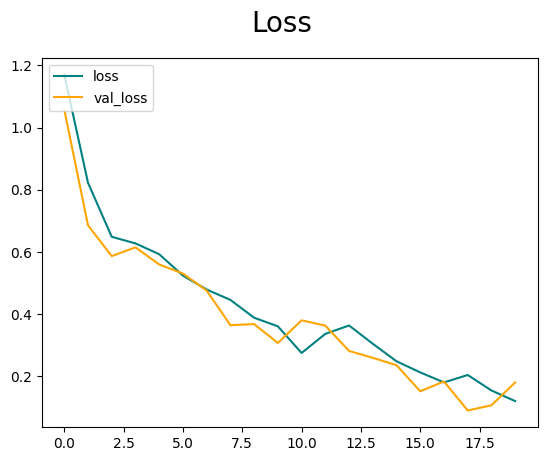

In [62]:
fig=plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

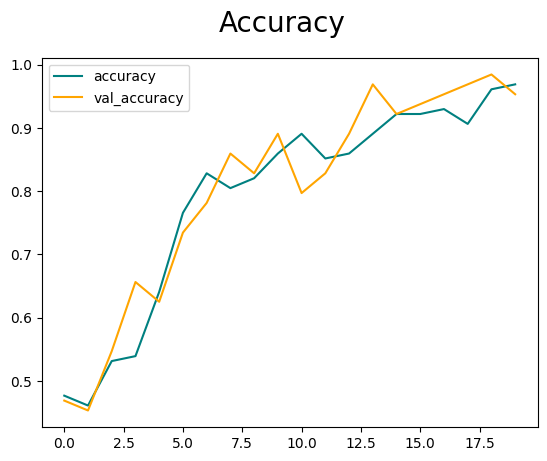

In [63]:
fig=plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

Evaluate Performance

In [64]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [65]:
pre=Precision()
re=Recall()
acc=BinaryAccuracy()

In [68]:
for batch in test.as_numpy_iterator():
    X,y=batch
    yhat=model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Precision:1.0, Recall:0.8333333134651184, Accuracy:0.8888888955116272


Test

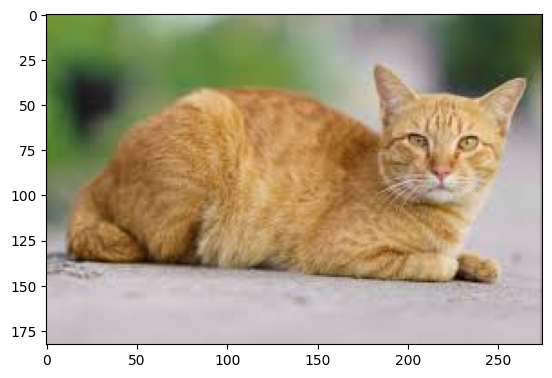

In [85]:
img=cv2.imread('cat_test.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

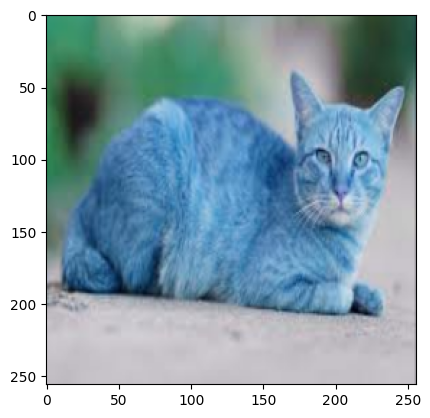

In [87]:
resize=tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [88]:
#our model was trained in batches, so during testing time, the model expects that a batch of images would be passed to test as well
np.expand_dims(resize,0)

yhat=model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [89]:
yhat
#correctly predicted as a cat

array([[0.03358759]], dtype=float32)

Saving the model

In [91]:
from tensorflow.keras.models import load_model

In [90]:
model.save(os.path.join('models', 'catlionmodel.h5'))

In [93]:
new_model=load_model(os.path.join('models', 'catlionmodel.h5'))

In [94]:
yhatnew=new_model.predict(np.expand_dims(resize/255,0))
yhatnew

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


array([[0.03358759]], dtype=float32)